In [ ]:
import cv2
import numpy as np
import mediapipe as mp

# Load image
image = cv2.imread("C:/Users/afolabi.faruq/Downloads/colgate_ea0e6caf29c7463782be47ba313b97be.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mp_face = mp.solutions.face_mesh
face_mesh = mp_face.FaceMesh(static_image_mode=True)

# Detect face landmarks
results = face_mesh.process(image_rgb)

if results.multi_face_landmarks:
    for face_landmarks in results.multi_face_landmarks:
        # Teeth area landmarks (rough region of mouth)
        mouth_ids = list(range(78, 88))  # MP upper teeth area
        
        points = []
        h, w, _ = image.shape
        for idx in mouth_ids:
            x = int(face_landmarks.landmark[idx].x * w)
            y = int(face_landmarks.landmark[idx].y * h)
            points.append([x, y])

        # Create a mask around teeth region
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        points = np.array(points, dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)

        # Extract teeth area
        teeth = cv2.bitwise_and(image, image, mask=mask)

        # Convert to HSV for brightness manipulation
        hsv = cv2.cvtColor(teeth, cv2.COLOR_BGR2HSV)
        
        h_ch, s_ch, v_ch = cv2.split(hsv)

        # Increase brightness and lower saturation for whitening
        v_ch = cv2.add(v_ch, 40)  # brighten
        s_ch = cv2.subtract(s_ch, 30)  # reduce saturation (less yellow)

        # Merge back
        hsv = cv2.merge([h_ch, s_ch, v_ch])
        whitened = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

        # Put whitened teeth back in original image
        final = image.copy()
        final[mask == 255] = whitened[mask == 255]

        cv2.imwrite("whitened_teeth.jpg", final)
        print("Teeth whitening completed! Saved as whitened_teeth.jpg")

else:
    print("Face not detected.")


Teeth whitening completed! Saved as whitened_teeth.jpg


In [ ]:
import cv2
import numpy as np

def whiten_teeth(image_path, output_path, whitening_factor=1.3):
    """
    Whiten teeth in an image with improved detection.
    
    Parameters:
    - image_path: path to input image
    - output_path: path to save the output image
    - whitening_factor: intensity of whitening (1.2-1.5 recommended)
    """
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not load image")
    
    original = img.copy()
    
    # Convert to different color spaces for better detection
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    # Method 1: HSV-based detection (yellow-white teeth)
    lower_teeth_hsv = np.array([0, 10, 100])
    upper_teeth_hsv = np.array([30, 150, 255])
    mask_hsv = cv2.inRange(hsv, lower_teeth_hsv, upper_teeth_hsv)
    
    # Method 2: YCrCb-based detection (better for varied lighting)
    lower_teeth_ycrcb = np.array([100, 130, 120])
    upper_teeth_ycrcb = np.array([255, 170, 150])
    mask_ycrcb = cv2.inRange(ycrcb, lower_teeth_ycrcb, upper_teeth_ycrcb)
    
    # Combine masks
    mask = cv2.bitwise_and(mask_hsv, mask_ycrcb)
    
    # Apply size filtering to remove small noise
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask_filtered = np.zeros_like(mask)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        # Only keep regions that could be teeth (not too small, not too large)
        if 50 < area < 5000:
            cv2.drawContours(mask_filtered, [contour], -1, 255, -1)
    
    # Aggressive morphological operations to clean up
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_medium = np.ones((5, 5), np.uint8)
    
    mask_filtered = cv2.morphologyEx(mask_filtered, cv2.MORPH_OPEN, kernel_small, iterations=2)
    mask_filtered = cv2.morphologyEx(mask_filtered, cv2.MORPH_CLOSE, kernel_medium, iterations=1)
    
    # Heavy blur for very smooth transitions
    mask_blurred = cv2.GaussianBlur(mask_filtered, (21, 21), 0)
    
    # Normalize mask
    mask_normalized = mask_blurred.astype(np.float32) / 255.0
    mask_3channel = np.stack([mask_normalized] * 3, axis=2)
    
    # Create whitened version using LAB color space for better control
    lab_whitened = lab.copy()
    
    # Increase L (lightness) channel
    lab_whitened[:, :, 0] = np.clip(
        lab_whitened[:, :, 0] + (30 * mask_normalized * whitening_factor),
        0, 255
    ).astype(np.uint8)
    
    # Shift a and b channels toward neutral (removes yellow)
    lab_whitened[:, :, 1] = np.clip(
        lab_whitened[:, :, 1] - (10 * mask_normalized),
        0, 255
    ).astype(np.uint8)
    
    lab_whitened[:, :, 2] = np.clip(
        lab_whitened[:, :, 2] - (10 * mask_normalized),
        0, 255
    ).astype(np.uint8)
    
    # Convert back to BGR
    whitened = cv2.cvtColor(lab_whitened, cv2.COLOR_LAB2BGR)
    
    # Blend with original
    img_float = original.astype(np.float32)
    whitened_float = whitened.astype(np.float32)
    result = (img_float * (1 - mask_3channel) + whitened_float * mask_3channel).astype(np.uint8)
    
    # Save the result
    cv2.imwrite(output_path, result)
    print(f"Whitened image saved to: {output_path}")
    
    # Optional: save mask for debugging
    debug_path = output_path.replace('.jpg', '_mask.jpg').replace('.png', '_mask.png')
    cv2.imwrite(debug_path, mask_blurred)
    print(f"Mask saved to: {debug_path}")
    
    return result

# Example usage
if __name__ == "__main__":
    input_image = "input.jpg"  # Replace with your image path
    output_image = "whitened_teeth.jpg"
    
    try:
        result = whiten_teeth(input_image, output_image, whitening_factor=1.3)
        print("Teeth whitening completed successfully!")
        print("Check the mask image to see what areas were detected as teeth")
        
    except Exception as e:
        print(f"Error: {e}")
    #input_image = "C:/Users/afolabi.faruq/Downloads/colgate_ea0e6caf29c7463782be47ba313b97be.jpg"  # Replace with your image path

Whitened image saved to: whitened_teeth.jpg
Teeth whitening completed successfully!


c:\Users\afolabi.faruq\Downloads\files_fixed (2)\env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Teeth whitening completed successfully!
Check the debug images to see detected regions


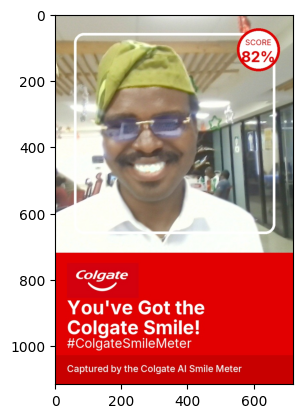

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

def whiten_teeth_mediapipe(image_path, output_path, whitening_intensity=40):
    """
    Whiten teeth using MediaPipe face mesh for accurate mouth detection.
    
    Parameters:
    - image_path: path to input image
    - output_path: path to save the output image
    - whitening_intensity: brightness increase (20-60 recommended)
    """
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=5,
        refine_landmarks=True,
        min_detection_confidence=0.5
    )
    
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Could not load image")
    
    original = img.copy()
    h, w, _ = img.shape
    
    # Convert to RGB for MediaPipe
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process image to get face landmarks
    results = face_mesh.process(img_rgb)
    
    if not results.multi_face_landmarks:
        print("No faces detected in the image!")
        return original
    
    # Lips landmarks indices (MediaPipe Face Mesh)
    # Inner lips: 78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 415, 310, 311, 312, 13, 82, 81, 80, 191
    # Outer lips: 61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 375, 321, 405, 314, 17, 84, 181, 91, 146
    
    UPPER_INNER_LIP = [78, 191, 80, 81, 82, 13, 312, 311, 310, 415]
    LOWER_INNER_LIP = [78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308, 415]
    
    # Combine for full inner mouth
    INNER_MOUTH = list(set(UPPER_INNER_LIP + LOWER_INNER_LIP))
    
    # Create a combined mask for all faces
    combined_mask = np.zeros((h, w), dtype=np.uint8)
    
    # Process each detected face
    for face_landmarks in results.multi_face_landmarks:
        # Get mouth region coordinates
        mouth_points = []
        for idx in INNER_MOUTH:
            landmark = face_landmarks.landmark[idx]
            x = int(landmark.x * w)
            y = int(landmark.y * h)
            mouth_points.append([x, y])
        
        mouth_points = np.array(mouth_points, dtype=np.int32)
        
        # Create mask for this mouth
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.fillPoly(mask, [mouth_points], 255)
        
        # Expand the mask slightly to catch more teeth
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=2)
        
        # Add to combined mask
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # Now detect teeth within the mouth region using color
    hsv = cv2.cvtColor(original, cv2.COLOR_BGR2HSV)
    
    # Detect bright, slightly yellow/white pixels (teeth)
    lower_teeth = np.array([0, 0, 120])
    upper_teeth = np.array([30, 100, 255])
    teeth_mask = cv2.inRange(hsv, lower_teeth, upper_teeth)
    
    # Combine: only teeth colors that are inside the mouth region
    teeth_mask = cv2.bitwise_and(teeth_mask, combined_mask)
    
    # Clean up the teeth mask
    kernel_small = np.ones((3, 3), np.uint8)
    teeth_mask = cv2.morphologyEx(teeth_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
    teeth_mask = cv2.morphologyEx(teeth_mask, cv2.MORPH_CLOSE, kernel_small, iterations=2)
    
    # Blur for smooth blending
    teeth_mask_blurred = cv2.GaussianBlur(teeth_mask, (15, 15), 0)
    
    # Normalize mask
    mask_normalized = teeth_mask_blurred.astype(np.float32) / 255.0
    
    # Convert to LAB for better color control
    lab = cv2.cvtColor(original, cv2.COLOR_BGR2LAB)
    lab_whitened = lab.copy()
    
    # Increase lightness (L channel)
    lab_whitened[:, :, 0] = np.clip(
        lab_whitened[:, :, 0] + (whitening_intensity * mask_normalized),
        0, 255
    ).astype(np.uint8)
    
    # Reduce yellow (adjust a and b channels toward neutral)
    lab_whitened[:, :, 1] = np.clip(
        lab_whitened[:, :, 1] - (8 * mask_normalized),
        0, 255
    ).astype(np.uint8)
    
    lab_whitened[:, :, 2] = np.clip(
        lab_whitened[:, :, 2] - (8 * mask_normalized),
        0, 255
    ).astype(np.uint8)
    
    # Convert back to BGR
    whitened = cv2.cvtColor(lab_whitened, cv2.COLOR_LAB2BGR)
    
    # Blend with original
    mask_3channel = np.stack([mask_normalized] * 3, axis=2)
    img_float = original.astype(np.float32)
    whitened_float = whitened.astype(np.float32)
    result = (img_float * (1 - mask_3channel) + whitened_float * mask_3channel).astype(np.uint8)
    
    # Save results
    cv2.imwrite(output_path, result)
    # print(f"Whitened image saved to: {output_path}")
    
    face_mesh.close()
    return result

# Example usage
if __name__ == "__main__":
    input_image = "C:/Users/afolabi.faruq/Downloads/colgate_42481f38bfac40959b5bc6c7b63ba8c0.jpg"  # Replace with your image path
    output_image = "whitened_teeth.jpg"
    
    try:
        result = whiten_teeth_mediapipe(input_image, output_image, whitening_intensity=40)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        print("Teeth whitening completed successfully!")
        print("Check the debug images to see detected regions")
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

In [14]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter

def enhance_for_social_media(img_bgr, enhancement_level='medium'):
    """
    Enhance image quality for social media sharing.
    Makes photos brighter, sharper, more vibrant and professional-looking.
    
    Parameters:
    - img_bgr: OpenCV BGR image (numpy array)
    - enhancement_level: 'light', 'medium', or 'strong'
    
    Returns:
    - Enhanced BGR image (numpy array)
    """
    
    # Convert BGR to PIL RGB for easier manipulation
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    
    # Set enhancement parameters based on level
    params = {
        'light': {
            'brightness': 1.10,
            'contrast': 1.15,
            'color': 1.20,
            'sharpness': 1.30,
            'warmth': 1.05
        },
        'medium': {
            'brightness': 1.15,
            'contrast': 1.25,
            'color': 1.35,
            'sharpness': 1.50,
            'warmth': 1.10
        },
        'strong': {
            'brightness': 1.20,
            'contrast': 1.35,
            'color': 1.50,
            'sharpness': 1.70,
            'warmth': 1.15
        }
    }
    
    settings = params.get(enhancement_level, params['medium'])
    
    # ============================================
    # 1. AUTO WHITE BALANCE (removes color casts)
    # ============================================
    img_lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    avg_a = np.average(img_lab[:, :, 1])
    avg_b = np.average(img_lab[:, :, 2])
    img_lab[:, :, 1] = img_lab[:, :, 1] - ((avg_a - 128) * 0.5)
    img_lab[:, :, 2] = img_lab[:, :, 2] - ((avg_b - 128) * 0.5)
    balanced_bgr = cv2.cvtColor(img_lab, cv2.COLOR_LAB2BGR)
    
    # Convert back to PIL for further processing
    pil_img = Image.fromarray(cv2.cvtColor(balanced_bgr, cv2.COLOR_BGR2RGB))
    
    # ============================================
    # 2. BRIGHTNESS ENHANCEMENT
    # ============================================
    enhancer = ImageEnhance.Brightness(pil_img)
    pil_img = enhancer.enhance(settings['brightness'])
    
    # ============================================
    # 3. CONTRAST ENHANCEMENT (makes image pop)
    # ============================================
    enhancer = ImageEnhance.Contrast(pil_img)
    pil_img = enhancer.enhance(settings['contrast'])
    
    # ============================================
    # 4. COLOR SATURATION (vibrant colors)
    # ============================================
    enhancer = ImageEnhance.Color(pil_img)
    pil_img = enhancer.enhance(settings['color'])
    
    # ============================================
    # 5. SHARPNESS (crisp details)
    # ============================================
    enhancer = ImageEnhance.Sharpness(pil_img)
    pil_img = enhancer.enhance(settings['sharpness'])
    
    # ============================================
    # 6. APPLY SUBTLE UNSHARP MASK (professional look)
    # ============================================
    pil_img = pil_img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))
    
    # ============================================
    # 7. SKIN TONE ENHANCEMENT (warm filter)
    # ============================================
    img_array = np.array(pil_img)
    
    # Apply warm tone by slightly increasing red channel
    img_array[:, :, 0] = np.clip(img_array[:, :, 0] * settings['warmth'], 0, 255)
    
    pil_img = Image.fromarray(img_array.astype('uint8'))
    
    # ============================================
    # 8. ADAPTIVE HISTOGRAM EQUALIZATION (improves details)
    # ============================================
    img_bgr_enhanced = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    
    # Convert to LAB for better control
    lab = cv2.cvtColor(img_bgr_enhanced, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel (brightness)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    
    # Merge back
    lab = cv2.merge([l, a, b])
    img_bgr_enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # ============================================
    # 9. REDUCE NOISE (smooth skin while keeping details)
    # ============================================
    img_bgr_enhanced = cv2.bilateralFilter(img_bgr_enhanced, d=9, sigmaColor=75, sigmaSpace=75)
    
    # ============================================
    # 10. SUBTLE VIGNETTE (focuses attention on center)
    # ============================================
    img_bgr_enhanced = apply_subtle_vignette(img_bgr_enhanced, intensity=0.3)
    
    return img_bgr_enhanced


def apply_subtle_vignette(img_bgr, intensity=0.3):
    """
    Apply a subtle vignette effect to focus attention on the center.
    
    Parameters:
    - img_bgr: OpenCV BGR image
    - intensity: 0.0 (none) to 1.0 (strong)
    """
    rows, cols = img_bgr.shape[:2]
    
    # Create radial gradient mask
    X_resultant_kernel = cv2.getGaussianKernel(cols, cols / 2)
    Y_resultant_kernel = cv2.getGaussianKernel(rows, rows / 2)
    
    # Create 2D kernel
    kernel = Y_resultant_kernel * X_resultant_kernel.T
    mask = kernel / kernel.max()
    
    # Adjust intensity
    mask = np.power(mask, intensity)
    
    # Apply to each channel
    output = img_bgr.copy()
    for i in range(3):
        output[:, :, i] = output[:, :, i] * mask
    
    return output.astype(np.uint8)


def apply_instagram_style_filter(img_bgr, filter_type='vibrant'):
    """
    Apply Instagram-style filters for different moods.
    
    Parameters:
    - img_bgr: OpenCV BGR image
    - filter_type: 'vibrant', 'warm', 'cool', 'vintage', 'dramatic'
    
    Returns:
    - Filtered BGR image
    """
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(img_rgb)
    
    if filter_type == 'vibrant':
        # High saturation, bright colors
        pil_img = ImageEnhance.Color(pil_img).enhance(1.4)
        pil_img = ImageEnhance.Brightness(pil_img).enhance(1.1)
        pil_img = ImageEnhance.Contrast(pil_img).enhance(1.2)
        
    elif filter_type == 'warm':
        # Warm golden tones
        img_array = np.array(pil_img)
        img_array[:, :, 0] = np.clip(img_array[:, :, 0] * 1.15, 0, 255)  # More red
        img_array[:, :, 2] = np.clip(img_array[:, :, 2] * 0.95, 0, 255)  # Less blue
        pil_img = Image.fromarray(img_array.astype('uint8'))
        
    elif filter_type == 'cool':
        # Cool blue tones
        img_array = np.array(pil_img)
        img_array[:, :, 0] = np.clip(img_array[:, :, 0] * 0.95, 0, 255)  # Less red
        img_array[:, :, 2] = np.clip(img_array[:, :, 2] * 1.15, 0, 255)  # More blue
        pil_img = Image.fromarray(img_array.astype('uint8'))
        
    elif filter_type == 'vintage':
        # Faded, retro look
        pil_img = ImageEnhance.Color(pil_img).enhance(0.8)
        pil_img = ImageEnhance.Contrast(pil_img).enhance(0.9)
        img_array = np.array(pil_img)
        # Add sepia tone
        sepia = np.array([[0.393, 0.769, 0.189],
                         [0.349, 0.686, 0.168],
                         [0.272, 0.534, 0.131]])
        img_array = cv2.transform(img_array, sepia)
        img_array = np.clip(img_array, 0, 255)
        pil_img = Image.fromarray(img_array.astype('uint8'))
        
    elif filter_type == 'dramatic':
        # High contrast, deep shadows
        pil_img = ImageEnhance.Contrast(pil_img).enhance(1.5)
        pil_img = ImageEnhance.Brightness(pil_img).enhance(0.95)
        pil_img = ImageEnhance.Color(pil_img).enhance(1.3)
    
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)


# Example usage
if __name__ == "__main__":
    # Test the enhancement
    img = cv2.imread("C:/Users/afolabi.faruq/Downloads/colgate_42481f38bfac40959b5bc6c7b63ba8c0.jpg")
    
    # Basic enhancement
    enhanced = enhance_for_social_media(img, enhancement_level='medium')
    cv2.imwrite("enhanced_medium.jpg", enhanced)
    
    # With Instagram-style filter
    filtered = apply_instagram_style_filter(img, filter_type='vibrant')
    cv2.imwrite("filtered_vibrant.jpg", filtered)
    
    print("Enhancement complete!")

Enhancement complete!
